In [79]:
# Install the required packages that are not included in the standard library.
!pip install numpy
!pip install pypdf

In [80]:
# Import the required libraries.
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Used to read the contents of a PDF file.
from pypdf import PdfReader

# Used to extract the contents of a zip file.
from zipfile import ZipFile

# Used plot the data.
import matplotlib.pyplot as plt

# Used to forecast the data.
from prophet import Prophet

# Add the custom_modules directory to sys.path
sys.path.append(Path("/resources"))

from forecastr import *

In [81]:
# We are using the Los Angeles Crime Dataset (2020 -- Present) to analyze the crime data in Los Angeles.
# Source: https://www.kaggle.com/datasets/nathaniellybrand/los-angeles-crime-dataset-2020-present/data

# Check if the CSV file is present in the resources folder. Unzip the file if it is not present.
zip_file_path = Path("resources/LA_CRIMES_2020to2024.zip")
csv_file_path = Path("resources/Crime_Data_from_2020_to_Present.csv")

if not csv_file_path.is_file():
    with ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extract("Crime_Data_from_2020_to_Present.csv", path="resources")

In [82]:
# Read the Los Angeles Crime Dataset (2020 -- Present) into a DataFrame.
df = pd.read_csv(csv_file_path)

In [83]:
# Add a new column to the DataFrame that provides a true/false value based on
# whether the crime was committed during the coronavirus pandemic stay-at-home order.
# Source: https://www.nbclosangeles.com/news/coronavirus/2020-2021-california-coronavirus-pandemic-timeline-key-events/2334100/

# The stay-at-home order in Los Angeles started on March 19, 2020, and ended on January 25, 2021.
start_date = pd.to_datetime("2020-03-19", format="%Y-%m-%d")
end_date = pd.to_datetime("2021-01-25", format="%Y-%m-%d")

# convert the DATE OCC column to datetime using format YYYY-MM-DD.
df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], format="mixed")

In [84]:
# Add a new column to the DataFrame that indicates whether the crime was committed during the stay-at-home order.
df["COVID SAH"] = np.where((df["DATE OCC"] >= start_date) & (df["DATE OCC"] <= end_date), True, False)

In [85]:
# Classify the crimes as Violent or Property crimes based on the Crime Code.
# Load the PDF file containing crime codes classifications of Violent and Property crimes.
pdf_file_path = Path("resources/UCR-COMPSTAT062618.pdf")
pdf_reader = PdfReader(pdf_file_path)

# Extract the text from the PDF file.
raw_pdf_content = "".join(page.extract_text() for page in pdf_reader.pages)

In [86]:
# Remove all new lines, tabs and extra spaces from the text. Then split the text by spaces.
pdf_content_list = raw_pdf_content.replace("\n", " ").replace("\t", " ").replace("  ", " ").replace(",", " ").split(" ")

# Create a dictionary to store the crime codes and their classifications.
crime_code_classification = {}

# iterate through the pdf_content_list to extract the crime codes and their classifications.
current_classification = None
for word in pdf_content_list:
    word = word.strip()
    if word == "Violent":
        current_classification = "VIOLENT"
    elif word == "Property":
        current_classification = "PROPERTY"
    else:
        # If the word is a crime code, store the current classification for that crime code.
        try:
            word = int(word)
        except ValueError:
            continue
        crime_code_classification[word] = current_classification

print(crime_code_classification)

# Assert known crime codes to their classifications at the known dividers.
assert crime_code_classification[310] == "PROPERTY"
assert crime_code_classification[491] == "PROPERTY"
assert crime_code_classification[110] == "VIOLENT"
assert crime_code_classification[930] == "VIOLENT"
assert crime_code_classification[926] == "VIOLENT"

{110: 'VIOLENT', 113: 'VIOLENT', 121: 'VIOLENT', 122: 'VIOLENT', 815: 'VIOLENT', 820: 'VIOLENT', 821: 'VIOLENT', 210: 'VIOLENT', 220: 'VIOLENT', 230: 'VIOLENT', 231: 'VIOLENT', 235: 'VIOLENT', 236: 'VIOLENT', 250: 'VIOLENT', 251: 'VIOLENT', 761: 'VIOLENT', 926: 'VIOLENT', 435: 'VIOLENT', 436: 'VIOLENT', 437: 'VIOLENT', 622: 'VIOLENT', 623: 'VIOLENT', 624: 'VIOLENT', 625: 'VIOLENT', 626: 'VIOLENT', 627: 'VIOLENT', 647: 'VIOLENT', 763: 'VIOLENT', 928: 'VIOLENT', 930: 'VIOLENT', 310: 'PROPERTY', 320: 'PROPERTY', 510: 'PROPERTY', 520: 'PROPERTY', 433: 'PROPERTY', 330: 'PROPERTY', 331: 'PROPERTY', 410: 'PROPERTY', 420: 'PROPERTY', 421: 'PROPERTY', 350: 'PROPERTY', 351: 'PROPERTY', 352: 'PROPERTY', 353: 'PROPERTY', 450: 'PROPERTY', 451: 'PROPERTY', 452: 'PROPERTY', 453: 'PROPERTY', 341: 'PROPERTY', 343: 'PROPERTY', 345: 'PROPERTY', 440: 'PROPERTY', 441: 'PROPERTY', 442: 'PROPERTY', 443: 'PROPERTY', 444: 'PROPERTY', 445: 'PROPERTY', 470: 'PROPERTY', 471: 'PROPERTY', 472: 'PROPERTY', 473: 'PRO

In [87]:
# Add a new column to the DataFrame that classifies the crime as Violent or Property.
df["CRIME CLASSIFICATION"] = df["Crm Cd"].map(crime_code_classification).fillna("OTHER")


In [88]:
# Add a new column to the DataFrame that provides the year of the crime.
df["YEAR OCC"] = df["DATE OCC"].dt.year

# Add a new column to the DataFrame that provides the month of the crime.
df["MONTH OCC"] = df["DATE OCC"].dt.month

<Figure size 1000x600 with 0 Axes>

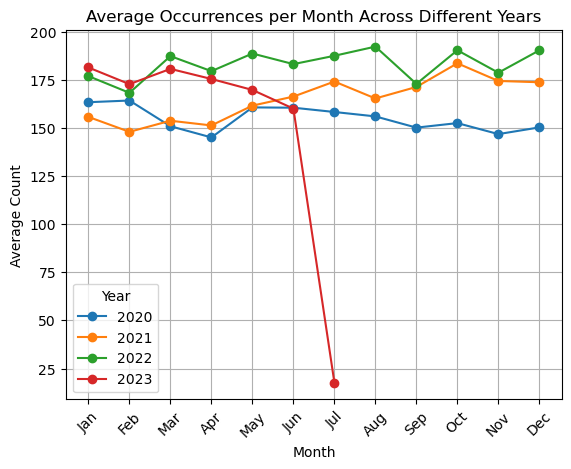

In [89]:
# Group by year, month, and crime description, then calculate the count
monthly_counts = df.groupby(['YEAR OCC', 'MONTH OCC', 'Crm Cd Desc'])['Crm Cd'].count().reset_index(name='count')

# Calculate the average count for each month
monthly_avg = monthly_counts.groupby(["MONTH OCC", "YEAR OCC"])['count'].mean().reset_index()

# Pivot the DataFrame to have years as columns
pivot_table = monthly_avg.pivot(index="MONTH OCC", columns="YEAR OCC", values='count')

# Plotting
plt.figure(figsize=(10, 6))
pivot_table.plot(marker='o')
plt.title('Average Occurrences per Month Across Different Years')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(title='Year')
plt.grid()
plt.show()

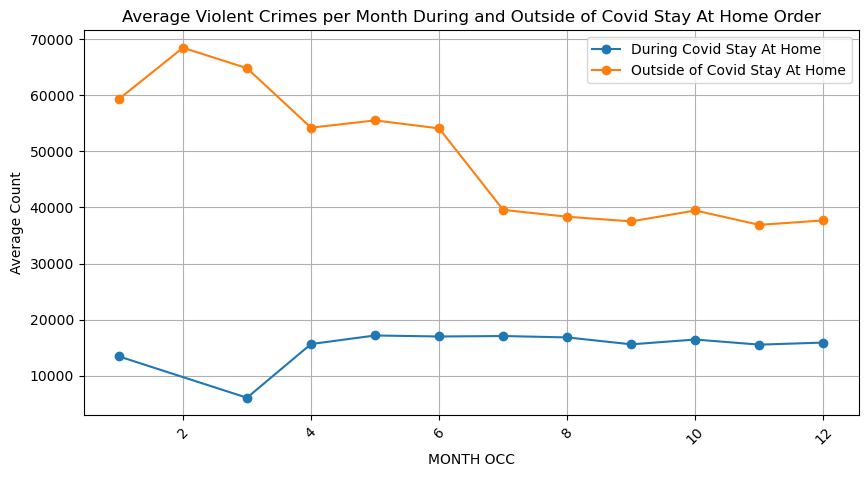

In [93]:
# Calculate the size of each group and rename it to 'count'
In_CovidLD_avg = df[df['COVID SAH'] == True].groupby('MONTH OCC').size().reset_index(name='count')

# Calculate average counts per month for false criteria
Non_CovidLD_avg = df[df['COVID SAH'] == False].groupby('MONTH OCC').size().reset_index(name='count')

# Combine the two DataFrames
avg_counts = pd.concat([In_CovidLD_avg, Non_CovidLD_avg])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(In_CovidLD_avg['MONTH OCC'], In_CovidLD_avg['count'], marker='o', label='During Covid Stay At Home')
plt.plot(Non_CovidLD_avg['MONTH OCC'], Non_CovidLD_avg['count'], marker='o', label='Outside of Covid Stay At Home')

plt.title('Average Violent Crimes per Month During and Outside of Covid Stay At Home Order')
plt.xlabel('MONTH OCC')
plt.ylabel('Average Count')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()